In [1]:

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
%cd /home/marcelo.silva/Projetos/BaseTrainer/seisden/notebooks

# Add the src folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))





/home/marcelo.silva/Projetos/BaseTrainer/seisden/notebooks


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from src.logging import PML_Logger
from src.trainer import PML_ModelTrainer
from src.templates import PML_BasicDataset


In [3]:
!ls /scratch/rsb/siren/siren-geo/public/dataset_warehouse/segeage/dataset/

input_train_rsf4.npy  target_train_rsf4.npy
input_val_rsf4.npy    target_val_rsf4.npy


In [3]:
#read seismic data from a file 
train_input = np.load('/scratch/rsb/siren/siren-geo/public/dataset_warehouse/segeage/dataset/input_train_rsf4.npy')
train_output = np.load('/scratch/rsb/siren/siren-geo/public/dataset_warehouse/segeage/dataset/target_train_rsf4.npy')

valid_input = np.load('/scratch/rsb/siren/siren-geo/public/dataset_warehouse/segeage/dataset/input_val_rsf4.npy')
valid_output = np.load('/scratch/rsb/siren/siren-geo/public/dataset_warehouse/segeage/dataset/target_val_rsf4.npy')


In [29]:
train_input.shape

(839, 1, 480, 480)

In [5]:
train_dataset = PML_BasicDataset(train_input, train_output, device='cuda')
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

sample_batch = train_dataloader.__iter__().__next__()


In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [4]:

class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, z_mean, z_log_var):
        batch = z_mean.size(0)
        dim = z_mean.size(1)
        epsilon = torch.randn(batch, dim).to(z_mean.device)  # Ensure epsilon is on the same device
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon


class VAE_Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim, input_shape, num_blocks=3, channels=None, activation=nn.ReLU):
        super().__init__()
        self.in_channels = in_channels
        self.latent_dim = latent_dim
        self.input_shape = input_shape
        self.num_blocks = num_blocks

        if channels is None:
            # Default: double channels each block
            channels = [32 * (2 ** i) for i in range(num_blocks)]
        assert len(channels) == num_blocks

        layers = []
        prev_ch = in_channels
        for ch in channels:
            layers.append(nn.Conv2d(prev_ch, ch, 3, padding=1))
            layers.append(activation())
            layers.append(nn.MaxPool2d(2))
            prev_ch = ch
        self.conv = nn.Sequential(*layers)

        # Compute flatten dim and output shape
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            enc_out = self.conv(dummy)
            self._flatten_dim = enc_out.view(1, -1).shape[1]
            self._enc_out_shape = enc_out.shape[1:]

        self.fc_mu = nn.Linear(self._flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self._flatten_dim, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    @property
    def flatten_dim(self):
        return self._flatten_dim

    @property
    def enc_out_shape(self):
        return self._enc_out_shape

    def get_enc_out_shape(self):
        return self._enc_out_shape

class VAE_Decoder(nn.Module):
    def __init__(self, out_channels, latent_dim, enc_out_shape, num_blocks=3, channels=None, activation=nn.ReLU):
        super().__init__()
        self.latent_dim = latent_dim
        self.enc_out_shape = enc_out_shape
        self.flatten_dim = int(torch.prod(torch.tensor(enc_out_shape)).item())
        self.num_blocks = num_blocks

        if channels is None:
            channels = [32 * (2 ** i) for i in range(num_blocks)]
        assert len(channels) == num_blocks

        # Reverse channels for decoder
        decoder_channels = list(reversed(channels))
        prev_ch = decoder_channels[0]

        self.fc = nn.Linear(latent_dim, self.flatten_dim)
        layers = [nn.Unflatten(1, enc_out_shape)]
        for i, ch in enumerate(decoder_channels[1:]):
            layers.append(nn.ConvTranspose2d(prev_ch, ch, 2, stride=2))
            layers.append(activation())
            prev_ch = ch
        # Final layer to output channels
        layers.append(nn.ConvTranspose2d(prev_ch, out_channels, 2, stride=2))
        layers.append(nn.Sigmoid())
        self.deconv = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = self.deconv(x)
        return x

class VAE(nn.Module):
    def __init__(self, in_channels, latent_dim, input_shape, num_blocks=3, channels=None, activation=nn.ReLU):
        super().__init__()
        self.encoder = VAE_Encoder(
            in_channels, latent_dim, input_shape, num_blocks=num_blocks, channels=channels, activation=activation
        )
        enc_out_shape = self.encoder.enc_out_shape
        self.decoder = VAE_Decoder(
            in_channels, latent_dim, enc_out_shape, num_blocks=num_blocks, channels=channels, activation=activation
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar




def vae_loss(y_hat, y):
    """
    y_hat: tuple (recon, mu, logvar) from VAE forward
    y: ground truth tensor
    """
    recon, mu, logvar = y_hat
    recon_loss = F.mse_loss(recon, y, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


# # Example Usage:
# if __name__ == '__main__':
#     input_shape = (1, 28, 28)  # Example: 1 channel, 28x28 images
#     latent_dim = 32
#     vae = VariationalAutoencoder(input_shape, latent_dim)

#     # Dummy data
#     data = torch.randn(64, *input_shape)  # Batch size 64

#     # Example of training step (simplified)
#     optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

#     vae.train()
#     for i in range(10): # Epochs
#         optimizer.zero_grad()
#         recon_batch, z_mean, z_log_var = vae(data)
#         loss = vae_loss(recon_batch, data, z_mean, z_log_var)
#         loss.backward()
#         optimizer.step()
#         print(f"Epoch {i}, Loss: {loss.item()}")


In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim, input_shape, num_blocks=3, channels=None, activation=nn.ReLU):
        super().__init__()
        if channels is None:
            channels = [32 * (2 ** i) for i in range(num_blocks)]
        assert len(channels) == num_blocks

        layers = []
        prev_ch = in_channels
        for ch in channels:
            layers.append(nn.Conv2d(prev_ch, ch, 3, padding=1))
            layers.append(activation())
            layers.append(nn.MaxPool2d(2))
            prev_ch = ch
        self.conv = nn.Sequential(*layers)

        # Compute flatten dim and output shape
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            enc_out = self.conv(dummy)
            self._flatten_dim = enc_out.view(1, -1).shape[1]
            self._enc_out_shape = enc_out.shape[1:]

        self.fc = nn.Linear(self._flatten_dim, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        z = self.fc(x)
        return z

    @property
    def flatten_dim(self):
        return self._flatten_dim

    @property
    def enc_out_shape(self):
        return self._enc_out_shape

class Decoder(nn.Module):
    def __init__(self, out_channels, latent_dim, enc_out_shape, num_blocks=3, channels=None, activation=nn.ReLU):
        super().__init__()
        if channels is None:
            channels = [32 * (2 ** i) for i in range(num_blocks)]
        assert len(channels) == num_blocks

        decoder_channels = list(reversed(channels))
        prev_ch = decoder_channels[0]

        self.fc = nn.Linear(latent_dim, int(torch.prod(torch.tensor(enc_out_shape)).item()))
        layers = [nn.Unflatten(1, enc_out_shape)]
        for ch in decoder_channels[1:]:
            layers.append(nn.ConvTranspose2d(prev_ch, ch, 2, stride=2))
            layers.append(activation())
            prev_ch = ch
        layers.append(nn.ConvTranspose2d(prev_ch, out_channels, 2, stride=2))
        layers.append(nn.Sigmoid())
        self.deconv = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = self.deconv(x)
        return x

class DenoisingAutoencoder(nn.Module):
    def __init__(self, in_channels, latent_dim, input_shape, num_blocks=3, channels=None, activation=nn.ReLU):
        super().__init__()
        self.encoder = Encoder(in_channels, latent_dim, input_shape, num_blocks, channels, activation)
        enc_out_shape = self.encoder.enc_out_shape
        self.decoder = Decoder(in_channels, latent_dim, enc_out_shape, num_blocks, channels, activation)

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon

In [16]:
# ——— prepare your data ———
train_dataset = PML_BasicDataset(train_input, train_output)  # both are numpy arrays
valid_dataset = PML_BasicDataset(valid_input, valid_output)


batch_size=128 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)



In [12]:
# ——— prepare your data ——— AUTOENCODER

def normalize_panels(x):
    # x: (N, H, W)
    x_min = x.min(axis=(1,2), keepdims=True)
    x_max = x.max(axis=(1,2), keepdims=True)
    return (x - x_min) / (x_max - x_min + 1e-10) 


train_input_norm = normalize_panels(train_input)
valid_input_norm = normalize_panels(valid_input)
print( f"train_input_norm.shape: {train_input_norm.shape} X {train_input.shape} train_input.shape")
print(f"valid_input_norm.shape: {valid_input_norm.shape} X {valid_input.shape} valid_input.shape")



train_dataset = PML_BasicDataset(train_input_norm, train_input_norm)  # both are numpy arrays
valid_dataset = PML_BasicDataset(valid_input_norm, valid_input_norm)


batch_size=256
num_workers=8
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers,
                          pin_memory=True)
valid_loader = DataLoader(valid_dataset,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          pin_memory=True)

train_input_norm.shape: (839, 1, 480, 480) X (839, 1, 480, 480) train_input.shape
valid_input_norm.shape: (361, 1, 480, 480) X (361, 1, 480, 480) valid_input.shape


In [6]:
# infer channel counts directly from your numpy arrays
in_ch  = train_input.shape[1]
out_ch = train_output.shape[1]


In [7]:
# Get a batch from the dataloader
x_batch, y_batch = next(iter(train_loader))
# x_batch shape: (batch_size, channels, height, width)
input_shape = tuple(x_batch.shape[1:])
print("Input shape:", input_shape)

Input shape: (1, 480, 480)


In [8]:
# ——— build model / loss / optimizer ———
# model     = SimpleCNN(in_channels=in_ch, out_channels=out_ch)
# loss_fn   = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

latent_dim=1024
num_blocks=4

model     = VAE(in_channels=in_ch, latent_dim=latent_dim, input_shape=input_shape, num_blocks=num_blocks, channels=None, activation=nn.ReLU)
# (in_channels=in_ch, out_channels=out_ch)

loss_fn   = vae_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
bestweight_filename = f"bestW_l{latent_dim}_nb_{num_blocks}.pth"

In [9]:
# Calculate total parameters and estimated memory usage
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def model_size_bytes(model):
    total = 0
    for p in model.parameters():
        total += p.numel() * p.element_size()
    return total

params = count_parameters(model)
size_bytes = model_size_bytes(model)
size_mb = size_bytes / (1024 ** 2)

print(f"Total parameters: {params:,}")
print(f"Estimated size: {size_bytes:,} bytes ({size_mb:.2f} MB)")

Total parameters: 708,581,473
Estimated size: 2,834,325,892 bytes (2703.02 MB)


In [13]:
# ——— plug into your trainer ———
trainer = PML_ModelTrainer(
    model      = model,
    loss_fn    = loss_fn,
    optimizer  = optimizer,
    train_loader = train_loader,
    valid_loader   = valid_loader,
)

No logger provided. Using default PML_Logger.
2025-08-06 17:35:25,709 - INFO:
  [trainer.py]:146- Using 4 GPUs with DataParallel.
2025-08-06 17:35:25,710 - INFO:
  [trainer.py]:156- Model moved to cuda
2025-08-06 17:35:25,712 - INFO:
  [trainer.py]:175- Seed set to 42 (deterministic=True)
2025-08-06 17:35:25,712 - INFO:
  [trainer.py]:120- Loaders set (train + valid)
2025-08-06 17:35:25,712 - INFO:
  [trainer.py]:105- PML_ModelTrainer initialized on device: cuda


In [ ]:
#load weights
state_dict = torch.load(bestweight_filename)
# If loading into a non-DataParallel model, strip 'module.' prefix
if list(state_dict.keys())[0].startswith("module."):
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_state_dict[k.replace("module.", "", 1)] = v
    model.load_state_dict(new_state_dict)
else:
    model.load_state_dict(state_dict)

In [14]:
# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [15]:
# ——— run! ———
hist = trainer.fit(n_epochs=2000,
                   best_model_path=bestweight_filename,
                   n_starting_epoch=0)

[Epoch 123] Saved new best (valid_loss=2.6475e+05)
2025-08-06 17:51:53,360 - INFO:
  [trainer.py]:226- [Epoch 123/2000] train_loss=2.9869e+05, valid_loss=2.6475e+05
[Epoch 123/2000] train_loss=2.9869e+05, valid_loss=2.6475e+05
2025-08-06 17:51:57,393 - INFO:
  [trainer.py]:226- [Epoch 124/2000] train_loss=2.9894e+05, valid_loss=2.6560e+05
[Epoch 124/2000] train_loss=2.9894e+05, valid_loss=2.6560e+05
2025-08-06 17:52:01,351 - INFO:
  [trainer.py]:226- [Epoch 125/2000] train_loss=2.9784e+05, valid_loss=2.6495e+05
[Epoch 125/2000] train_loss=2.9784e+05, valid_loss=2.6495e+05
2025-08-06 17:52:04,977 - INFO:
  [trainer.py]:226- [Epoch 126/2000] train_loss=2.9809e+05, valid_loss=2.6639e+05
[Epoch 126/2000] train_loss=2.9809e+05, valid_loss=2.6639e+05
[Epoch 127] Saved new best (valid_loss=2.6456e+05)
2025-08-06 17:52:16,527 - INFO:
  [trainer.py]:226- [Epoch 127/2000] train_loss=2.9775e+05, valid_loss=2.6456e+05
[Epoch 127/2000] train_loss=2.9775e+05, valid_loss=2.6456e+05
2025-08-06 17:52:2

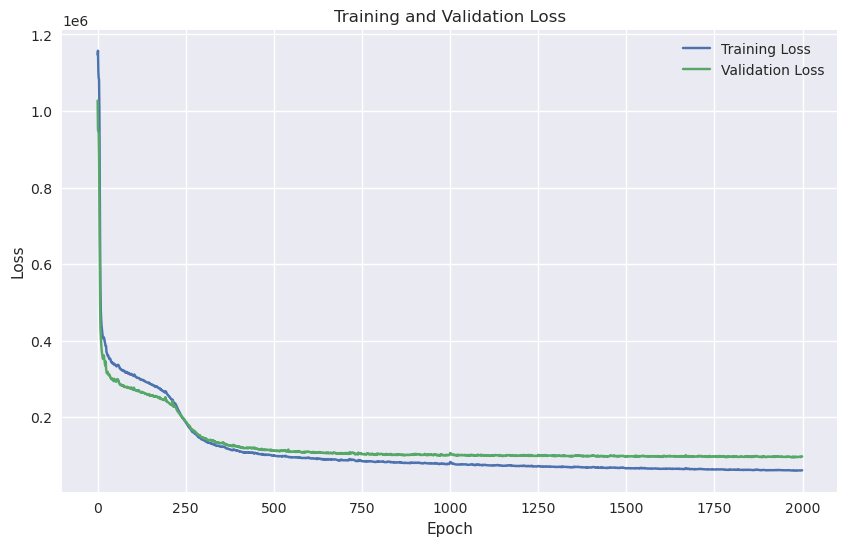

In [17]:
import matplotlib.pyplot as plt

# Use seaborn style for plots
plt.style.use('seaborn-v0_8')

# If your trainer has a history attribute with loss values, plot them

history = hist
plt.figure(figsize=(10, 6))
if 'train' in history:
    plt.plot(history['train'], label='Training Loss')
if 'valid' in history:
    plt.plot(history['valid'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
single_batch = valid_loader.__iter__().__next__()
# Run a single batch through the model
with torch.no_grad():
    model.eval()
    x_batch, y_batch = single_batch
    x_batch = x_batch.to('cuda')
    y_batch = y_batch.to('cuda')
    
    output = model(x_batch)
    output = output[0]  # Get the reconstruction output from the VAE
    print(f"Input shape: {x_batch.shape}, Output shape: {output.shape}, Target shape: {y_batch.shape}")


Input shape: torch.Size([256, 1, 480, 480]), Output shape: torch.Size([256, 1, 480, 480]), Target shape: torch.Size([256, 1, 480, 480])


In [16]:
import matplotlib.pyplot as plt



In [26]:
# Assuming `output`, `x_batch`, and `y_batch` are tensors from your model
# Select a random index
random_idx = torch.randint(0, x_batch.size(0), (1,)).item()

# Extract the corresponding data
x_sample = x_batch[random_idx].cpu().detach().numpy()
y_sample = y_batch[random_idx].cpu().detach().numpy()
output_sample = output[random_idx].cpu().detach().numpy()


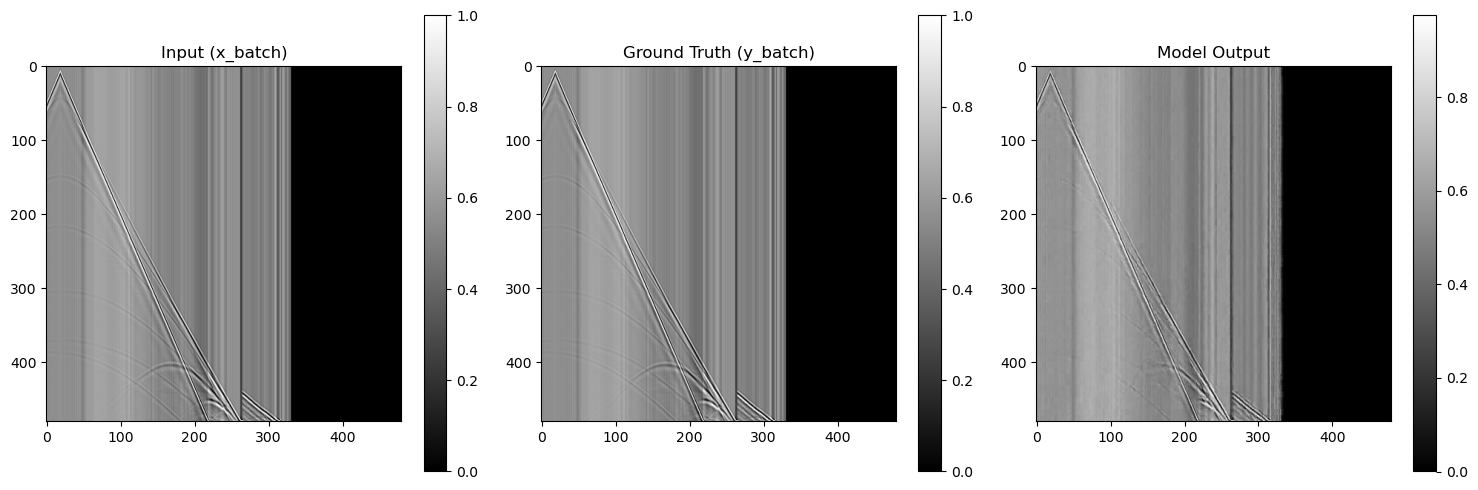

In [27]:
# Plot the data
plt.figure(figsize=(15, 5))

# Plot x_batch
plt.subplot(1, 3, 1)
plt.title("Input (x_batch)")
plt.imshow(x_sample[0], cmap='gray')  # Assuming x_batch has a single channel
plt.colorbar()

# Plot y_batch
plt.subplot(1, 3, 2)
plt.title("Ground Truth (y_batch)")
plt.imshow(y_sample[0], cmap='gray')  # Assuming y_batch has a single channel
plt.colorbar()

# Plot output
plt.subplot(1, 3, 3)
plt.title("Model Output")
plt.imshow(output_sample[0], cmap='gray')  # Assuming output has a single channel
plt.colorbar()

plt.tight_layout()
plt.show()

In [21]:
def plot_seismic_data_2D_perc(data, clip_percentile=99):
    """
    Plota dados sísmicos 2D aplicando corte de percentil para eliminar outliers.
    
    Parâmetros
    ----------
    data : array_like
        Matriz 2D de amplitudes sísmicas (tempo × traços).
    clip_percentile : float, opcional
        Percentil superior para o corte. Default é 99.
        O percentil inferior será automaticamente (100 - clip_percentile).
    """
    # calcula os limites de corte
    p_low  = 100.0 - clip_percentile
    p_high = clip_percentile
    vmin = np.percentile(data, p_low)
    vmax = np.percentile(data, p_high)
    
    # aplica o corte (opcional, não altera data original)
    data_clipped = np.clip(data, vmin, vmax)
    
    # plota
    plt.figure(figsize=(10, 6))
    im = plt.imshow(data_clipped, aspect='auto', cmap='gray',
                    vmin=vmin, vmax=vmax)
    plt.colorbar(im, label='Amplitude')
    plt.title('Seismic Data (clipped at %g%%)' % clip_percentile)
    plt.xlabel('Trace Number')
    plt.ylabel('Time Sample')
    plt.show()

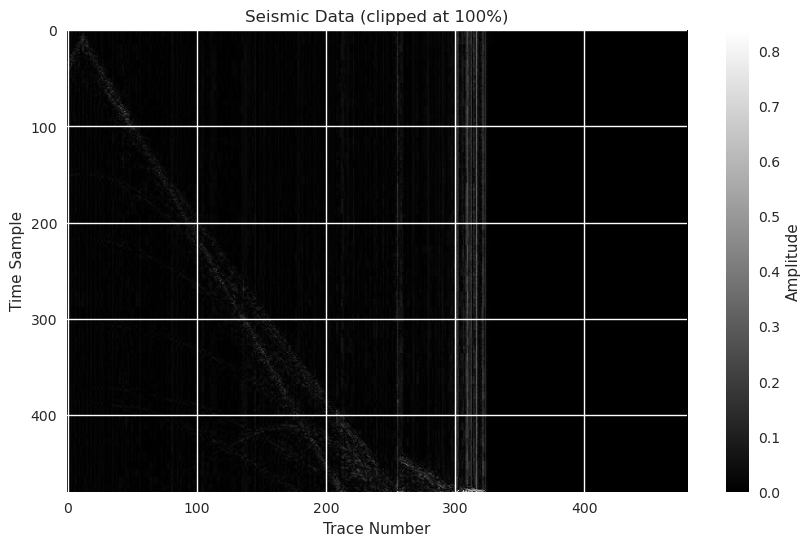

In [22]:
# plot_seismic_data_2D_perc( train_input_norm[200, 0, :, :], clip_percentile=100)
random_idx = torch.randint(0, x_batch.size(0), (1,)).item()

# Extract the corresponding data
x_sample = x_batch[random_idx].cpu().detach().numpy()
y_sample = y_batch[random_idx].cpu().detach().numpy()
output_sample = output[random_idx].cpu().detach().numpy()
plot_seismic_data_2D_perc( np.abs(output_sample[0]- y_sample[0]), clip_percentile=100)
# plot_seismic_data_2D_perc( output_sample[


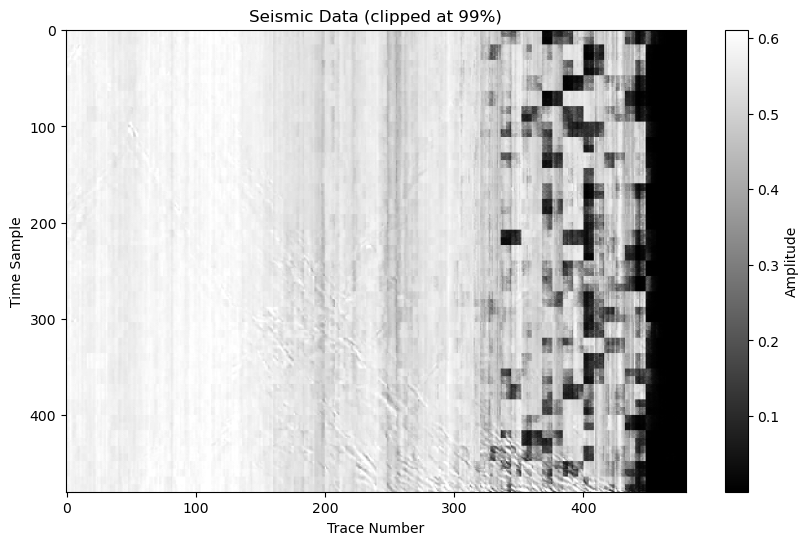

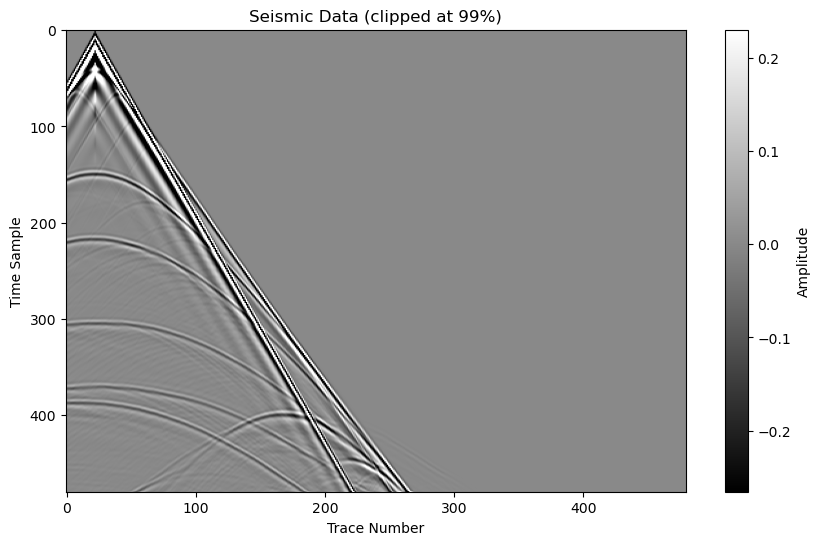

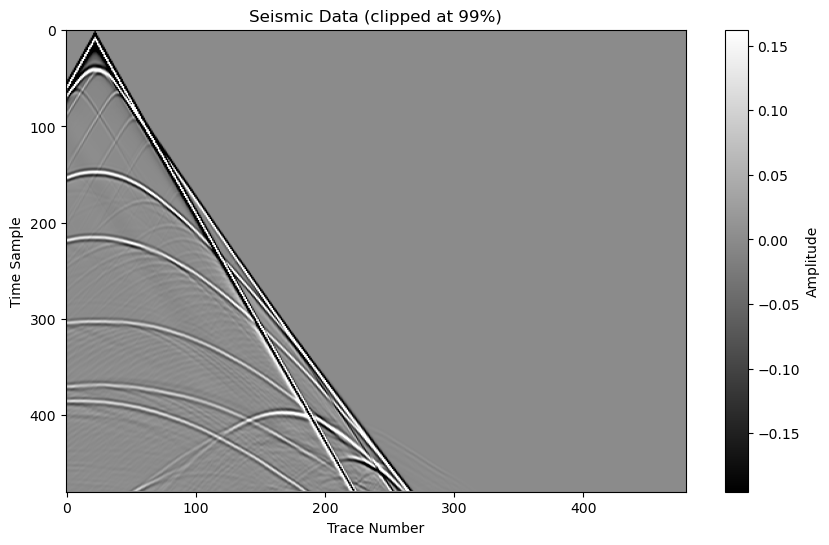

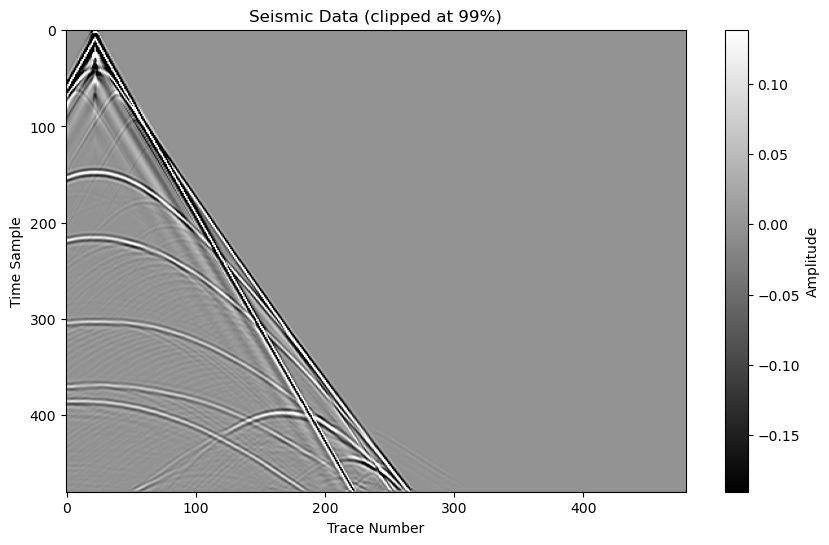

In [23]:
# Assuming `output`, `x_batch`, and `y_batch` are tensors from your model
# Select a random index
random_idx = torch.randint(0, x_batch.size(0), (1,)).item()

# Extract the corresponding data
x_sample = x_batch[random_idx].cpu().detach().numpy().squeeze()
y_sample = y_batch[random_idx].cpu().detach().numpy().squeeze()
output_sample = output[random_idx].cpu().detach().numpy().squeeze()


plot_seismic_data_2D_perc(x_sample, clip_percentile=99)
plot_seismic_data_2D_perc(y_sample, clip_percentile=99)
plot_seismic_data_2D_perc(output_sample, clip_percentile=99)